In [264]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [265]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,XLU.Low,XLU.Close,XLU.Volume,XLU.Adjusted,XLRE.Open,XLRE.High,XLRE.Low,XLRE.Close,XLRE.Volume,XLRE.Adjusted
849,2019-05-20,180.490005,181.179993,179.339996,179.949997,38608300,179.949997,202.800003,206.000000,195.250000,...,58.709999,58.860001,9118700,58.860001,36.509998,36.570000,35.919998,36.049999,3472100,36.049999
850,2019-05-21,181.500000,182.330002,180.919998,181.830002,31613800,181.830002,197.759995,207.399994,196.039993,...,58.810001,58.970001,11504400,58.970001,36.209999,36.455002,36.150002,36.349998,2353600,36.349998
851,2019-05-22,180.820007,182.070007,180.750000,181.020004,24332600,181.020004,199.100006,203.940002,191.779999,...,58.880001,59.410000,9257900,59.410000,36.389999,36.549999,36.310001,36.520000,1982800,36.520000
852,2019-05-23,178.940002,179.020004,177.139999,178.250000,45351300,178.250000,194.339996,199.470001,186.220001,...,59.410000,59.919998,15164500,59.919998,36.419998,36.735001,36.360001,36.700001,2521100,36.700001
853,2019-05-24,179.210007,179.850006,177.940002,178.160004,25885600,178.160004,199.830002,199.979996,188.750000,...,59.759998,59.830002,8712400,59.830002,36.860001,36.990002,36.740002,36.750000,1523600,36.750000


In [266]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data_orig.tail()

,Index,volatilityQQQ,volatilityTSLA,volatilityMSFT,volatilityINTC,volatilityAAPL,volatilityNFLX,volatilityAMZN,volatilityFB,volatilityGOOG,...,volatilityXLB,volatilityXLI,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE
849,2019-05-20,0.252685,0.481600,0.260094,0.340511,0.373833,0.325481,0.285106,0.281882,0.317193,...,0.200739,0.191919,0.199266,0.110759,0.122998,0.189780,0.269788,0.222987,0.151159,0.124564
850,2019-05-21,0.264113,0.489254,0.261268,0.387658,0.405106,0.343711,0.285349,0.294165,0.323497,...,0.221569,0.205990,0.205222,0.112259,0.133840,0.201185,0.283061,0.242188,0.117787,0.129286
851,2019-05-22,0.263815,0.535393,0.262349,0.286721,0.409748,0.357345,0.283970,0.295299,0.323710,...,0.220613,0.209850,0.210322,0.111044,0.136005,0.203063,0.282333,0.230469,0.115043,0.129796
852,2019-05-23,0.271672,0.572564,0.262205,0.302312,0.409422,0.373515,0.307195,0.318660,0.326085,...,0.217066,0.218731,0.215441,0.093721,0.138184,0.208100,0.292086,0.247085,0.088779,0.119618
853,2019-05-24,0.195552,0.541981,0.193429,0.252312,0.279113,0.274943,0.240998,0.252034,0.289028,...,0.186115,0.157418,0.145425,0.076635,0.071508,0.142033,0.206949,0.190810,0.081608,0.119175


In [267]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .rename(columns={'Index_x':'Index'})

In [268]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [269]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [270]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .fillna(-1)

In [272]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [273]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [274]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if (('Open' in i[1]) or ("volatility" in i[1]))])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'BABA': 193,
 'BP': 199,
 'BUD': 205,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'FB': 43,
 'GLD': 181,
 'GLW': 211,
 'GOOG': 49,
 'HD': 157,
 'INTC': 19,
 'JNJ': 109,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 133,
 'PANW': 127,
 'PFE': 217,
 'PG': 103,
 'QQQ': 1,
 'RHT': 139,
 'SBUX': 79,
 'SFIX': 223,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 229,
 'T': 235,
 'TGT': 91,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 241,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85,
 'XLB': 253,
 'XLE': 247,
 'XLF': 283,
 'XLI': 259,
 'XLK': 289,
 'XLP': 271,
 'XLRE': 307,
 'XLU': 301,
 'XLV': 277,
 'XLY': 265,
 'XTL': 295,
 'volatilityAAPL': 317,
 'volatilityAMD': 325,
 'volatilityAMZN': 319,
 'volatilityBABA': 345,
 'volatilityBP': 346,
 'volatilityBUD': 347,
 'volatilityDATA': 324,
 'volatilityDIS': 338,
 'volatilityDUK': 340,
 'volatilityFB': 320,
 'volatilityGLD': 343,
 'volatilityGLW': 348,
 'volatilityGOOG': 321,
 'volatilityHD': 339,
 'volatility

In [275]:
days_lookback = 1
pct_df = data_orig.iloc[:,1:].shift(days_lookback).fillna(-1)
pct_df

,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,...,MEHOINUSA672N,PCU33443344,MPU9900063,IPMAN,SP500,FEDFUNDS,UNRATE,T10Y2Y,DATE,CBBTCUSD
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
1,109.449997,109.599998,108.120003,109.500000,50807600.0,106.223091,230.720001,231.380005,219.000000,223.410004,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
2,110.040001,110.180000,108.800003,109.309998,38795200.0,106.038773,226.360001,226.889999,220.000000,223.429993,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
3,107.410004,108.889999,107.410004,108.260002,41891100.0,105.020172,220.000000,220.050003,215.979996,219.039993,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
4,105.949997,107.290001,104.809998,104.870003,61386300.0,101.731651,214.190002,218.440002,213.669998,215.649994,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
5,105.629997,106.290001,103.900002,104.010002,69344000.0,100.897369,217.860001,220.440002,210.770004,211.000000,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
6,104.750000,105.059998,102.730003,104.330002,49767900.0,101.207802,214.009995,214.449997,203.000000,207.850006,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
7,105.330002,106.080002,104.080002,105.540001,46734200.0,102.381592,211.600006,213.740005,205.309998,209.970001,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
8,105.970001,106.230003,101.739998,101.900002,69870700.0,98.850510,212.009995,212.649994,200.000000,200.309998,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
9,102.300003,104.980003,100.669998,104.070000,78445700.0,100.955582,202.210007,210.000000,193.380005,206.179993,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000


In [286]:
data_orig.drop("DATE", axis=1, inplace=True)
pct_df.drop("DATE", axis=1, inplace=True)
data_orig.drop("Index", axis=1, inplace=True)
# pct_df.drop("Index", axis=1, inplace=True)

In [279]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map

{'AAPL.Open': 4,
 'AMD.Open': 12,
 'AMZN.Open': 6,
 'BABA.Open': 32,
 'BP.Open': 33,
 'BUD.Open': 34,
 'DATA.Open': 11,
 'DIS.Open': 25,
 'DUK.Open': 27,
 'FB.Open': 7,
 'GLD.Open': 30,
 'GLW.Open': 35,
 'GOOG.Open': 8,
 'HD.Open': 26,
 'INTC.Open': 3,
 'JNJ.Open': 18,
 'JWN.Open': 16,
 'KO.Open': 19,
 'MSFT.Open': 2,
 'NFLX.Open': 5,
 'NVDA.Open': 22,
 'PANW.Open': 21,
 'PFE.Open': 36,
 'PG.Open': 17,
 'QQQ.Open': 0,
 'RHT.Open': 23,
 'SBUX.Open': 13,
 'SFIX.Open': 37,
 'SLV.Open': 31,
 'SPOT.Open': 28,
 'SQ.Open': 9,
 'STX.Open': 38,
 'T.Open': 39,
 'TGT.Open': 15,
 'TSLA.Open': 1,
 'TWTR.Open': 10,
 'USO.Open': 24,
 'V.Open': 40,
 'VRSN.Open': 20,
 'WDC.Open': 29,
 'WMT.Open': 14,
 'XLB.Open': 42,
 'XLE.Open': 41,
 'XLF.Open': 47,
 'XLI.Open': 43,
 'XLK.Open': 48,
 'XLP.Open': 45,
 'XLRE.Open': 51,
 'XLU.Open': 50,
 'XLV.Open': 46,
 'XLY.Open': 44,
 'XTL.Open': 49,
 'volatilityAAPL.Open': 56,
 'volatilityAMD.Open': 64,
 'volatilityAMZN.Open': 58,
 'volatilityBABA.Open': 84,
 'volati

In [287]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig)

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)
pctdf_mat = scaler.transform(pct_df)

In [288]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [289]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [290]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pctdf_mat[:int(row)] # Needs to be N-day shift
x_test = result[int(row):, :]
y_test = pctdf_mat[int(row):]  # Needs to be N-day shift

[x_train, y_train, x_test, y_test]

[array([[[0.56821961, 0.56818919, 0.56815899, ..., 0.6512111 ,
          0.65047189, 0.64954524],
         [0.712434  , 0.71249126, 0.71254903, ..., 0.72957241,
          0.72798834, 0.72622285],
         [0.61194859, 0.61196841, 0.61198845, ..., 0.69358845,
          0.69257468, 0.69137544],
         ...,
         [0.83355733, 0.83356161, 0.83356585, ..., 0.69474866,
          0.69255308, 0.69034115],
         [0.79816307, 0.7981943 , 0.79822581, ..., 0.71409114,
          0.71206485, 0.71002101],
         [0.70894149, 0.70903058, 0.70912032, ..., 0.75463359,
          0.75304215, 0.75143007]],
 
        [[0.712434  , 0.71249126, 0.71254903, ..., 0.72957241,
          0.72798834, 0.72622285],
         [0.61194859, 0.61196841, 0.61198845, ..., 0.69358845,
          0.69257468, 0.69137544],
         [0.45104767, 0.45109662, 0.451146  , ..., 0.70696443,
          0.70679381, 0.70643172],
         ...,
         [0.79816307, 0.7981943 , 0.79822581, ..., 0.71409114,
          0.71206485, 0.

In [148]:
LAYERS = 30
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('linear'))

start = time.time()
# adam = Adam(lr=0.1)
model.compile(loss='mse', optimizer="adam")
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 389..., units=30)`
  import sys


compilation time :  0.019010066986083984


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=389)`
  app.launch_new_instance()


In [291]:
MODELNAME = 'multiplemodeltest_medusa'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [304]:
VALIDATIONSIZE = 0.10
EPOCHS = 500
model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=1024,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 618 samples, validate on 69 samples
Epoch 1/500
618/618 [==============================] - 5s 8ms/step - loss: 0.1556 - val_loss: 0.0538
Epoch 2/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1534 - val_loss: 0.0540
Epoch 3/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1546 - val_loss: 0.0541
Epoch 4/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1511 - val_loss: 0.0543
Epoch 5/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1533 - val_loss: 0.0545
Epoch 6/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1504 - val_loss: 0.0550

Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 7/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1554 - val_loss: 0.0552
Epoch 8/500
618/618 [==============================] - 1s 2ms/step - loss: 0.1506 - val_loss: 0.0555
Epoch 9/500
618/618 [==============================] - 1s 2ms/step

In [305]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [306]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

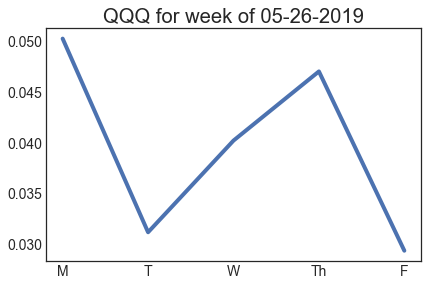

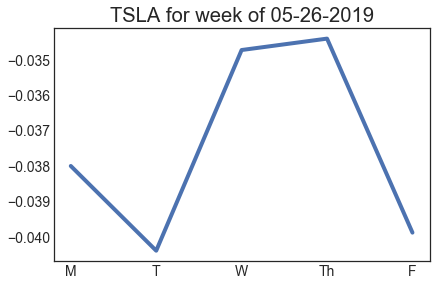

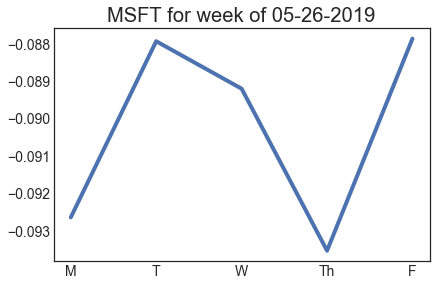

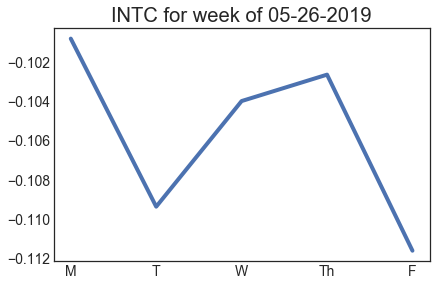

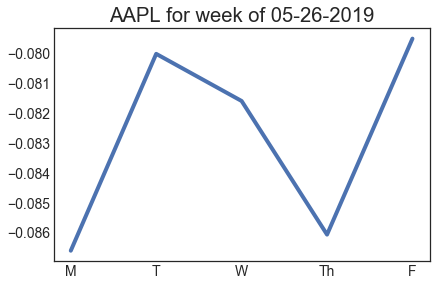

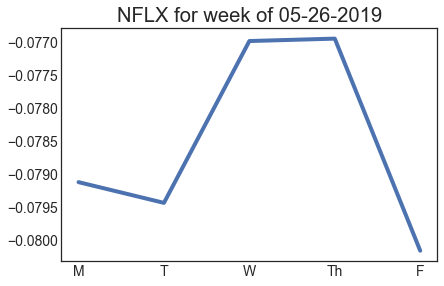

In [ ]:
for t in list(ticker_lookup.keys()):
    plt.style.use('seaborn-white')
    plt.title(str(t)+" for week of "+"05-26-2019")
    plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    if "volatility" in t:
        plt.savefig('../reports/'+t.split("volatility")[1]+'_volatility_prediction.png')
    else:
        plt.savefig('../reports/'+t+'_prediction.png')
    plt.show()

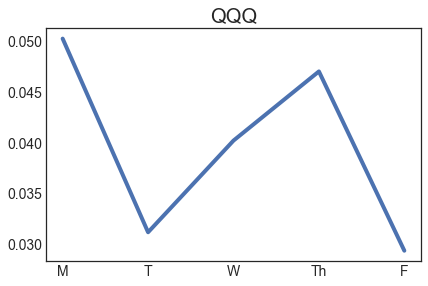

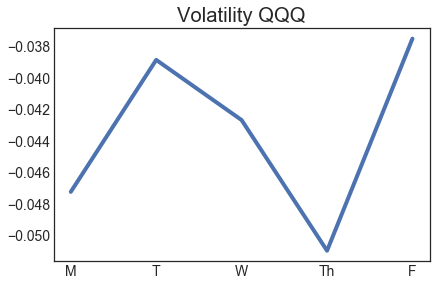

In [317]:
t = "QQQ"
plt.style.use('seaborn-white')
plt.title(t)
plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

plt.title("Volatility "+t)
plt.plot([i[ticker_lookup["volatility"+t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

In [311]:
f = open("instructions.txt", "w")
day_lookup = dict(enumerate(["M", "T", "W", "Th", "F"]))
strategy = {}
strategy["LONG"] = {"BUY" : {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}, "SELL": {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}}
strategy["SHORT"] = {"BUY" : {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}, "SELL": {"M":{}, "T":{}, "W":{}, "Th":{}, "F":{}}}
tu = []
for t in list(ticker_lookup.keys()):
    week = [i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))]
    week_min = min(week)
    week_max = max(week)
    max_index = [i for i, v in enumerate(week) if v == week_max][0]
    min_index = [i for i, v in enumerate(week) if v == week_min][0]
    if min_index > max_index:
        print("LONG", t, "BUY ON", day_lookup[max_index], "SELL ON", day_lookup[min_index])
        f.write("LONG "+str(t)+" BUY ON "+str(day_lookup[max_index])+" SELL ON "+str(day_lookup[min_index])+'\n')
        strategy["LONG"]["BUY"][day_lookup[max_index]][t] = {"SELL" : day_lookup[min_index]}
        tu.append((0, t, max_index, min_index))
    else:
        print("SHORT", t, "SELL ON", day_lookup[min_index], "BUY ON", day_lookup[max_index])
        f.write("SHORT "+str(t)+" SELL ON "+str(day_lookup[min_index])+" BUY ON "+str(day_lookup[max_index])+'\n')
        strategy["SHORT"]["SELL"][day_lookup[min_index]][t] = {"BUY" : day_lookup[max_index]}
        tu.append((1, t, max_index, min_index))
        
f.close()

LONG QQQ BUY ON M SELL ON F
SHORT TSLA SELL ON T BUY ON Th
SHORT MSFT SELL ON Th BUY ON F
LONG INTC BUY ON M SELL ON F
SHORT AAPL SELL ON M BUY ON F
LONG NFLX BUY ON Th SELL ON F
LONG AMZN BUY ON Th SELL ON F
LONG FB BUY ON M SELL ON F
LONG GOOG BUY ON Th SELL ON F
SHORT SQ SELL ON Th BUY ON F
SHORT TWTR SELL ON M BUY ON F
SHORT DATA SELL ON M BUY ON F
SHORT AMD SELL ON Th BUY ON F
SHORT SBUX SELL ON W BUY ON Th
SHORT WMT SELL ON Th BUY ON F
SHORT TGT SELL ON Th BUY ON F
SHORT JWN SELL ON T BUY ON Th
SHORT PG SELL ON T BUY ON W
LONG JNJ BUY ON W SELL ON F
SHORT KO SELL ON Th BUY ON F
SHORT VRSN SELL ON M BUY ON F
SHORT PANW SELL ON Th BUY ON F
SHORT NVDA SELL ON T BUY ON W
SHORT RHT SELL ON Th BUY ON F
LONG USO BUY ON W SELL ON F
LONG DIS BUY ON T SELL ON Th
SHORT HD SELL ON Th BUY ON F
LONG DUK BUY ON T SELL ON Th
LONG SPOT BUY ON T SELL ON Th
LONG WDC BUY ON M SELL ON Th
LONG GLD BUY ON T SELL ON Th
LONG SLV BUY ON M SELL ON Th
SHORT BABA SELL ON M BUY ON F
SHORT BP SELL ON M BUY ON 

In [234]:
sorted(tu)

[(0, 'SBUX', 0, 3),
 (0, 'XLF', 2, 3),
 (0, 'XLI', 0, 2),
 (0, 'volatilityBUD', 0, 3),
 (0, 'volatilityGLW', 0, 3),
 (0, 'volatilityHD', 0, 2),
 (0, 'volatilityMSFT', 0, 3),
 (0, 'volatilityT', 1, 3),
 (0, 'volatilityV', 1, 3),
 (0, 'volatilityVRSN', 2, 3),
 (0, 'volatilityXLE', 0, 2),
 (0, 'volatilityXLK', 1, 3),
 (1, 'AAPL', 3, 0),
 (1, 'AMD', 2, 0),
 (1, 'AMZN', 1, 0),
 (1, 'BABA', 3, 0),
 (1, 'BP', 1, 0),
 (1, 'BUD', 4, 3),
 (1, 'DATA', 4, 1),
 (1, 'DIS', 3, 0),
 (1, 'DUK', 2, 0),
 (1, 'FB', 4, 0),
 (1, 'GLD', 2, 0),
 (1, 'GLW', 1, 0),
 (1, 'GOOG', 4, 0),
 (1, 'HD', 2, 0),
 (1, 'INTC', 2, 0),
 (1, 'JNJ', 2, 0),
 (1, 'JWN', 1, 0),
 (1, 'KO', 3, 0),
 (1, 'MSFT', 1, 0),
 (1, 'NFLX', 1, 0),
 (1, 'NVDA', 4, 0),
 (1, 'PANW', 3, 0),
 (1, 'PFE', 2, 0),
 (1, 'PG', 4, 0),
 (1, 'QQQ', 4, 3),
 (1, 'RHT', 3, 0),
 (1, 'SFIX', 3, 1),
 (1, 'SLV', 2, 0),
 (1, 'SPOT', 2, 0),
 (1, 'SQ', 3, 0),
 (1, 'STX', 4, 0),
 (1, 'T', 2, 0),
 (1, 'TGT', 2, 0),
 (1, 'TSLA', 4, 1),
 (1, 'TWTR', 3, 0),
 (1, 'USO', 2